In [1]:
## ANALYSE ENSEMBLES
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser

def calculate_center_of_mass(atoms):
    """Calculate the center of mass of a set of atoms."""
    total_mass = sum(atom.mass for atom in atoms)
    com = sum(atom.mass * np.array(atom.coord) for atom in atoms) / total_mass
    return com

def calculate_radius_of_gyration(pdb_file):
    """Calculate the radius of gyration (Rg) from a PDB file."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("structure", pdb_file)

    atoms = []
    
    # Iterate over atoms and store mass-weighted coordinates
    for atom in structure.get_atoms():
        if atom.element != 'H':  # Exclude hydrogens
            atoms.append(atom)

    if not atoms:
        raise ValueError("No valid atoms found in the PDB file.")

    # Calculate center of mass
    com = calculate_center_of_mass(atoms)

    # Compute radius of gyration
    rg = np.sqrt(sum(atom.mass * np.linalg.norm(atom.coord - com) ** 2 for atom in atoms) / sum(atom.mass for atom in atoms))
    
    return rg, len(atoms)

from pathlib import Path
pdbids = [pdbid for pdbid in os.listdir('/proj/wallner-b/users/x_yogka/cfold/ablation/data/cfold_data/test/') if pdbid not in ['out', 'trained_on', 'error']]
native_structures_with_train_confs = "/proj/wallner-b/users/x_yogka/cfold/ablation/data/cfold_data/native_structures_with_train_confs"
native_structures_with_test_confs  = "/proj/wallner-b/users/x_yogka/cfold/ablation/data/cfold_data/native_structures_with_test_confs"

datapath = '/proj/wallner-b/users/x_yogka/cfold/ablation/data/'
outpath = '/proj/wallner-b/users/x_yogka/cfold/ablation/data/results_cfold'

In [ ]:
# PROCESS ENSEMBLES
import os, glob

for protein in list(pdbids):
    try:
        ref1 = glob.glob(f'{native_structures_with_test_confs}/{protein}*.pdb')
        ref2 = f"{native_structures_with_train_confs}/{'_'.join(Path(ref1[0]).stem.split('_')[::-1])}.pdb"

        rg = (calculate_radius_of_gyration(ref1[0]), calculate_radius_of_gyration(ref2))
        title = Path(ref1[0]).stem+ f' Rg: {rg[0][0]:.2f}, {rg[0][1]:.2f} (test), {rg[1][0]:.2f},{rg[1][1]:.2f} (train)'
    #print(f' Rg: {rg[0]:.2f} (test), {rg[1]:.2f} (train)')
    except:
        print('Problem with references', protein)
        continue

    ref1.extend([ref2])
    pdbpaths = ref1
    pdbpaths_ = ','.join(pdbpaths)
    #print(pdbpaths_)
    
    df_ = []
    for method  in ['vanilla', 'afsample2']:
        print('---------------------')
        print(protein, method)
        print('---------------------')
        afoutpath = f'{datapath}/cfold_data/test/{protein}/{method}'

        outcsv = f'{outpath}/{method}/final_df_{protein}_{len(pdbpaths)}_states.csv'
        #print(outcsv)
        if os.path.exists(outcsv):
            print(f'{outcsv} exists')
        else:
            models = glob.glob(f'{afoutpath}/*pdb')
            if len(models) == 2000:
                cmd = (
                    f'python /proj/wallner-b/users/x_yogka/sidekick/airy/src/landscape/analyse_ensembles.py '
                    f'--method {method} '
                    f'--protein {protein} '
                    f'--afout_path {afoutpath} '
                    f'--outpath {outpath} '
                    f'--ncpu 32 '
                    f'--refstates {pdbpaths_} '
                    f'--log on'
                    )        
            
                os.system(cmd)
            else:
                print(f'Only {len(models)} files found!!!')
                continue

vanilla
afsample2


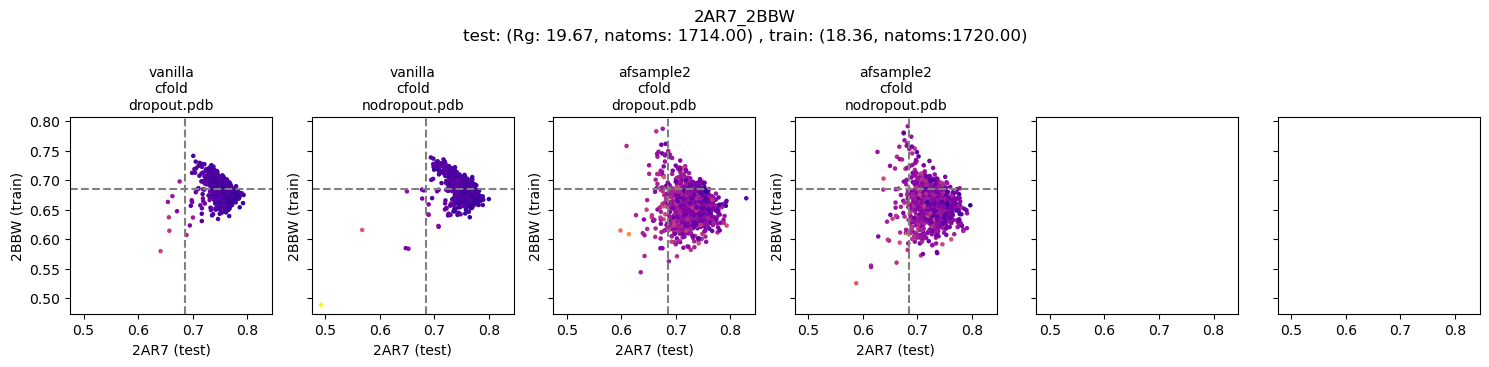

In [42]:
from utils import tmalign_and_extract_scores
import seaborn as sns 
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
import pandas as pd
import glob

for protein in list(pdbids):
    try:
        ref1 = glob.glob(f'{native_structures_with_test_confs}/{protein}*.pdb')[0]
        ref2 = f"{native_structures_with_train_confs}/{'_'.join(Path(ref1).stem.split('_')[::-1])}.pdb"

        rg = (calculate_radius_of_gyration(ref1), calculate_radius_of_gyration(ref2))
        title = Path(ref1).stem+ f'\ntest: (Rg: {rg[0][0]:.2f}, natoms: {rg[0][1]:.2f}) , train: ({rg[1][0]:.2f}, natoms:{rg[1][1]:.2f})'

    except:
        print('Problem with references', protein)
        continue
    
    reftm, refrm = tmalign_and_extract_scores(ref1, ref2)
    references = [ref1, ref2]
    pdbpaths_ = ','.join(references)
    
    df_ = []
    for method  in ['vanilla', 'afsample2']:
        outcsv = f'{outpath}/{method}/final_df_{protein}_{len(references)}_states.csv'
        if os.path.exists(outcsv):
            df = pd.read_csv(outcsv)
            df['method']=df.model.str.split('/', expand=True)[11]
            df['network']=[model.split('unrelaxed')[-1].split('_')[1] for model in df.model]
            df['dropout'] = df.model.str.split('_', expand=True).iloc[:, -1:]
            df['id'] = df['method'] + '_' + df['network'] + '_' + df['dropout']
        df_.append(df)
        print(method)
    
    df_concat = pd.concat(df_)
    if len(df_concat.id.unique())==4:
        fig, axes = plt.subplots(1, 6, figsize=(15, 3.7), sharex=True, sharey=True)
        for ax, i in zip(axes, df_concat.id.unique()):
            df_ = df_concat[(df_concat.id == i)]
            norm = plt.Normalize(df_concat['confidence'].min(), df_concat['confidence'].max())
            ax.scatter(df_[df_.columns[4]], df_[df_.columns[5]], s=5, c=df_['confidence'], cmap='plasma_r', norm=norm)
            ax.set_xlabel(df_concat.columns[4].split('_')[3]+ ' (test)')
            ax.set_ylabel(df_concat.columns[5].split('_')[3]+' (train)')
            ax.set_title('\n'.join(i.split('_')), fontsize=10)
            ax.axvline(x=reftm, ls='--', color='gray')
            ax.axhline(y=reftm, ls='--', color='gray')

        fig.suptitle(title)
        
        plt.tight_layout()
        plt.show()

    break

In [26]:
df_concat

,model,confidence,tm_w_best,rm_w_best,tm_w_s0_2AR7_2BBW,tm_w_s1_2BBW_2AR7,protein,method,network,dropout,id
0,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,84.448733,0.94749,1.13,0.76921,0.67975,2AR7,vanilla,cfold,dropout.pdb,vanilla_cfold_dropout.pdb
1,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,84.008733,0.94960,1.38,0.75244,0.68528,2AR7,vanilla,cfold,nodropout.pdb,vanilla_cfold_nodropout.pdb
2,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,84.819548,0.96527,0.84,0.75805,0.67624,2AR7,vanilla,cfold,dropout.pdb,vanilla_cfold_dropout.pdb
3,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,84.305249,0.94410,1.42,0.77663,0.66957,2AR7,vanilla,cfold,dropout.pdb,vanilla_cfold_dropout.pdb
4,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,84.795385,0.93805,0.96,0.74529,0.69543,2AR7,vanilla,cfold,nodropout.pdb,vanilla_cfold_nodropout.pdb
...,...,...,...,...,...,...,...,...,...,...,...
1995,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,81.977466,0.90773,1.32,0.71441,0.64581,2AR7,afsample2,cfold,dropout.pdb,afsample2_cfold_dropout.pdb
1996,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,80.946199,0.92215,1.08,0.71881,0.65334,2AR7,afsample2,cfold,nodropout.pdb,afsample2_cfold_nodropout.pdb
1997,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,82.682172,0.85354,1.91,0.72603,0.66115,2AR7,afsample2,cfold,dropout.pdb,afsample2_cfold_dropout.pdb
1998,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,83.290950,0.90135,1.71,0.73378,0.67536,2AR7,afsample2,cfold,dropout.pdb,afsample2_cfold_dropout.pdb


In [41]:
best_models_s1 = pd.DataFrame(columns=['protein']+df_concat.id.unique().tolist())
best_models_s2 = pd.DataFrame(columns=['protein']+df_concat.id.unique().tolist())
best_models_s1

,protein,vanilla_cfold_dropout.pdb,vanilla_cfold_nodropout.pdb,afsample2_cfold_dropout.pdb,afsample2_cfold_nodropout.pdb


In [31]:
['protein'].append(['protein'].extend(df_concat.id.unique()))

In [38]:
df.groupby('id')[df_concat.columns[4]].max().reset_index()

,id,tm_w_s0_2AR7_2BBW
0,afsample2_cfold_dropout.pdb,0.82892
1,afsample2_cfold_nodropout.pdb,0.79691


In [19]:
pd.concat([df.groupby('id')[df_concat.columns[4]].max().reset_index().T, df.groupby('id')[df_concat.columns[5]].max().reset_index().T])

,0,1
id,afsample2_cfold_dropout.pdb,afsample2_cfold_nodropout.pdb
tm_w_s0_2AR7_2BBW,0.82892,0.79691
id,afsample2_cfold_dropout.pdb,afsample2_cfold_nodropout.pdb
tm_w_s1_2BBW_2AR7,0.78711,0.79128


In [3]:
df_concat

,model,confidence,tm_w_best,rm_w_best,tm_w_s0_2AR7_2BBW,tm_w_s1_2BBW_2AR7,protein,method,network,dropout,id
0,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,84.448733,0.94749,1.13,0.76921,0.67975,2AR7,vanilla,cfold,dropout.pdb,vanilla_cfold_dropout.pdb
1,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,84.008733,0.94960,1.38,0.75244,0.68528,2AR7,vanilla,cfold,nodropout.pdb,vanilla_cfold_nodropout.pdb
2,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,84.819548,0.96527,0.84,0.75805,0.67624,2AR7,vanilla,cfold,dropout.pdb,vanilla_cfold_dropout.pdb
3,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,84.305249,0.94410,1.42,0.77663,0.66957,2AR7,vanilla,cfold,dropout.pdb,vanilla_cfold_dropout.pdb
4,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,84.795385,0.93805,0.96,0.74529,0.69543,2AR7,vanilla,cfold,nodropout.pdb,vanilla_cfold_nodropout.pdb
...,...,...,...,...,...,...,...,...,...,...,...
1995,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,81.977466,0.90773,1.32,0.71441,0.64581,2AR7,afsample2,cfold,dropout.pdb,afsample2_cfold_dropout.pdb
1996,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,80.946199,0.92215,1.08,0.71881,0.65334,2AR7,afsample2,cfold,nodropout.pdb,afsample2_cfold_nodropout.pdb
1997,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,82.682172,0.85354,1.91,0.72603,0.66115,2AR7,afsample2,cfold,dropout.pdb,afsample2_cfold_dropout.pdb
1998,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,83.290950,0.90135,1.71,0.73378,0.67536,2AR7,afsample2,cfold,dropout.pdb,afsample2_cfold_dropout.pdb


In [ ]:
def plot_auc(self):
    p = sns.color_palette()
    colors = [p[0], p[2], p[3], p[4], p[6], p[1]]

    fig, ax = plt.subplots(1, figsize=(4, 4))
    for mode, color in zip(self.best_tms_o.columns[1:], colors):
        roc = []
        for threshold in np.arange(0.01, 1.01, 0.01):
            roc.append(self.best_tms_o[(self.best_tms_o[f'{mode}'] > threshold) & 
                                (self.best_tms_c[f'{mode}'] > threshold)].shape[0])
        
        ax.plot(np.arange(0.01, 1.01, 0.01), 
                self.min_max_scaling(roc), 
                label=f'{mode} (AUC: {np.round(integrate.trapezoid(self.min_max_scaling(roc), np.arange(0.01, 1.01, 0.01)), 2)})',
                color=color)

    ax.set_ylabel('Fraction of successful targets')
    ax.set_xlabel('TM-score threshold')
    ax.grid(color='gray', linestyle='--', linewidth=1)
    ax.legend(fontsize=9, title='AUC')  # Improve legend readability
    ax.set_xlim(0,1)
    ax.set_ylim(0,1.01)
    ax.set_title(self.dataset) 

    plt.show()

,model,confidence,tm_w_best,rm_w_best,tm_w_s0_1Y1A_1XO5,tm_w_s1_1XO5_1Y1A,protein,method,network,dropout,id
0,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,72.431093,0.80122,2.39,0.41440,0.69712,1Y1A,afsample2,cfold,dropout.pdb,afsample2_cfold_dropout.pdb
1,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,76.053060,0.85462,1.95,0.44838,0.74477,1Y1A,afsample2,cfold,nodropout.pdb,afsample2_cfold_nodropout.pdb
2,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,76.808743,0.77920,2.60,0.43305,0.72202,1Y1A,afsample2,cfold,nodropout.pdb,afsample2_cfold_nodropout.pdb
3,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,74.172077,0.83408,2.48,0.43321,0.73935,1Y1A,afsample2,cfold,nodropout.pdb,afsample2_cfold_nodropout.pdb
4,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,75.965137,0.82376,1.98,0.41848,0.74928,1Y1A,afsample2,cfold,nodropout.pdb,afsample2_cfold_nodropout.pdb
...,...,...,...,...,...,...,...,...,...,...,...
1995,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,73.823115,0.85620,1.61,0.43377,0.79488,1Y1A,afsample2,cfold,dropout.pdb,afsample2_cfold_dropout.pdb
1996,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,75.357104,0.80829,2.00,0.44093,0.72194,1Y1A,afsample2,cfold,nodropout.pdb,afsample2_cfold_nodropout.pdb
1997,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,73.054044,0.83659,1.87,0.40848,0.73973,1Y1A,afsample2,cfold,dropout.pdb,afsample2_cfold_dropout.pdb
1998,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,69.765027,0.77155,2.54,0.37308,0.72108,1Y1A,afsample2,cfold,dropout.pdb,afsample2_cfold_dropout.pdb


In [24]:
df.model.values

array(['/proj/wallner-b/users/x_yogka/cfold/ablation/data/cfold_data/test/2AR7/afsample2/unrelaxed_cfold_pred_454_rand0.2_dropout.pdb',
       '/proj/wallner-b/users/x_yogka/cfold/ablation/data/cfold_data/test/2AR7/afsample2/unrelaxed_cfold_pred_387_rand0.2_nodropout.pdb',
       '/proj/wallner-b/users/x_yogka/cfold/ablation/data/cfold_data/test/2AR7/afsample2/unrelaxed_cfold_pred_348_rand0.2_nodropout.pdb',
       ...,
       '/proj/wallner-b/users/x_yogka/cfold/ablation/data/cfold_data/test/2AR7/afsample2/unrelaxed_cfold_pred_825_rand0.2_dropout.pdb',
       '/proj/wallner-b/users/x_yogka/cfold/ablation/data/cfold_data/test/2AR7/afsample2/unrelaxed_cfold_pred_89_rand0.2_dropout.pdb',
       '/proj/wallner-b/users/x_yogka/cfold/ablation/data/cfold_data/test/2AR7/afsample2/unrelaxed_cfold_pred_958_rand0.2_nodropout.pdb'],
      shape=(2000,), dtype=object)

In [137]:
ref1


['/proj/wallner-b/users/x_yogka/cfold/ablation/data/cfold_data/native_structures_with_test_confs/2AR7_2BBW.pdb',
 '/proj/wallner-b/users/x_yogka/cfold/ablation/data/cfold_data/native_structures_with_train_confs/2BBW_2AR7.pdb']

In [123]:
f'{native_structures_with_test_confs}/{protein}*.pdb'

'/proj/wallner-b/users/x_yogka/cfold/ablation/data/cfold_data/native_structures_with_test_confs/1RML*.pdb'

In [79]:
fig, axes = plt.subplots(1, 6, figsize=(13, 3.3), sharex=True, sharey=True)
for ax in axes:
    sc = ax.scatter(stacked_df_[stacked_df_.columns[4]], stacked_df_[stacked_df_.columns[5]], s=5, c=stacked_df_['confidence'], cmap='plasma_r', norm=norm)

,model,confidence,tm_w_best,rm_w_best,tm_w_s0_2AR7_2BBW,tm_w_s1_2BBW_2AR7,protein
0,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,82.738914,0.84510,2.04,0.73956,0.61851,2AR7
1,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,80.525249,0.82761,2.28,0.69499,0.70757,2AR7
2,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,81.177014,0.91087,1.54,0.75126,0.67090,2AR7
3,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,79.548778,0.77156,2.46,0.66979,0.65487,2AR7
4,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,80.723710,0.82747,1.91,0.67644,0.76752,2AR7
...,...,...,...,...,...,...,...
1995,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,81.977466,0.90773,1.32,0.71441,0.64581,2AR7
1996,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,80.946199,0.92215,1.08,0.71881,0.65334,2AR7
1997,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,82.682172,0.85354,1.91,0.72603,0.66115,2AR7
1998,/proj/wallner-b/users/x_yogka/cfold/ablation/d...,83.290950,0.90135,1.71,0.73378,0.67536,2AR7


In [80]:
df.model.str.split('/', expand=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,,proj,wallner-b,users,x_yogka,cfold,ablation,data,cfold_data,test,2AR7,afsample2,unrelaxed_cfold_pred_454_rand0.2_dropout.pdb
1,,proj,wallner-b,users,x_yogka,cfold,ablation,data,cfold_data,test,2AR7,afsample2,unrelaxed_cfold_pred_387_rand0.2_nodropout.pdb
2,,proj,wallner-b,users,x_yogka,cfold,ablation,data,cfold_data,test,2AR7,afsample2,unrelaxed_cfold_pred_348_rand0.2_nodropout.pdb
3,,proj,wallner-b,users,x_yogka,cfold,ablation,data,cfold_data,test,2AR7,afsample2,unrelaxed_cfold_pred_496_rand0.2_nodropout.pdb
4,,proj,wallner-b,users,x_yogka,cfold,ablation,data,cfold_data,test,2AR7,afsample2,unrelaxed_cfold_pred_112_rand0.2_nodropout.pdb
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,,proj,wallner-b,users,x_yogka,cfold,ablation,data,cfold_data,test,2AR7,afsample2,unrelaxed_cfold_pred_848_rand0.2_dropout.pdb
1996,,proj,wallner-b,users,x_yogka,cfold,ablation,data,cfold_data,test,2AR7,afsample2,unrelaxed_cfold_pred_150_rand0.2_nodropout.pdb
1997,,proj,wallner-b,users,x_yogka,cfold,ablation,data,cfold_data,test,2AR7,afsample2,unrelaxed_cfold_pred_825_rand0.2_dropout.pdb
1998,,proj,wallner-b,users,x_yogka,cfold,ablation,data,cfold_data,test,2AR7,afsample2,unrelaxed_cfold_pred_89_rand0.2_dropout.pdb


In [41]:
from pathlib import Path


'2BBW_2AR7'

In [ ]:
a = [pdb.split('_')[0] for pdb in os.listdir(native_structures_with_train_confs) if pdb not in ['out', 'trained_on', 'error', 'fetch_native.sh']]
b = [pdb.split('_')[1].split('.')[0] for pdb in os.listdir(native_structures_with_test_confs) if pdb not in ['out', 'trained_on', 'error', 'fetch_native.sh']]
import collections
collections.Counter(a + b)

In [14]:
native_structures_with_test_confs

'/proj/wallner-b/users/x_yogka/cfold/ablation/data/cfold_data/native_structures_with_test_confs'

(['2QDF_3EFC.pdb',
  '5HAZ_5HAY.pdb',
  '5TZY_5TZR.pdb',
  '2H2Z_2QCY.pdb',
  '5M6S_1U5P.pdb',
  '6VGU_6MFS.pdb',
  '6NC7_6NC9.pdb',
  '4LAV_4LAW.pdb',
  '6YED_6YE8.pdb',
  '1EEH_2WJP.pdb',
  '2DRI_1URP.pdb',
  '6E8F_5T4M.pdb',
  '3TG8_4QGB.pdb',
  '1FNH_3R8Q.pdb',
  '6B7Q_5YIM.pdb',
  '3BIS_3BIK.pdb',
  '7T4T_7T4U.pdb',
  '1XO5_1Y1A.pdb',
  '7TBQ_7TBN.pdb',
  '4TVY_4TVW.pdb',
  '7PAG_3NSJ.pdb',
  '2RIK_3B43.pdb',
  '3L3F_3PSP.pdb',
  '5LEC_5LE2.pdb',
  '3AQP_5YHF.pdb',
  '4KQP_6H30.pdb',
  '6GOX_5K9T.pdb',
  '7ZU4_7ZU3.pdb',
  '7SY9_8DP2.pdb',
  '7LZ9_7LZA.pdb',
  '2AOB_3IMJ.pdb',
  '4QIQ_4GC0.pdb',
  '3K6U_3K6X.pdb',
  '5MSW_5MSS.pdb',
  '1T3W_6CBR.pdb',
  '6HAB_5E86.pdb',
  '3VKI_3TEE.pdb',
  '2ZGZ_1MWK.pdb',
  '3AXC_2W9N.pdb',
  '4RLY_5Y4D.pdb',
  '5FTY_5FTX.pdb',
  '7CML_3E7O.pdb',
  '2NRW_2NRV.pdb',
  '4X8H_4X8L.pdb',
  '3Q5D_3Q5E.pdb',
  '5ZJK_5CZW.pdb',
  '3IIA_3PLQ.pdb',
  '5E85_5E84.pdb',
  '6MFX_6MFY.pdb',
  '5C59_5LJ8.pdb',
  '4B3X_4KJZ.pdb',
  '1N0Y_4OY4.pdb',
  '1XD4_3KSY

In [2]:
from pathlib import Path
import os, glob
pdbids = [pdbid for pdbid in os.listdir('/proj/wallner-b/users/x_yogka/cfold/ablation/data/cfold_data/test/') if pdbid not in ['out', 'trained_on', 'error']]
len(pdbids)

244